In [1]:
import re
import glob
import json
import warnings
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS 
from graphviz import Digraph
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from heapq import nlargest
from pyLDAvis import sklearn as sklearn_lda
from pyLDAvis import gensim
import pickle 
import pyLDAvis
import os
os.environ["PATH"] += os.pathsep + 'C:\\graphviz\\bin'
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import nltk

In [3]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/arthur/vlibras-
[nltk_data]     libs/aelius/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [33]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [7]:
def get_dist_sentiment(lista):
    dist_sentiment = dict()
    for each in lista:
        aux = list()
        for item in graphs[each]:
            aux.append(graphs[each].nodes[item]['sentiment'])
        dist_sentiment[each] = np.array(aux)
    positives = dict()
    negatives = dict()
    for i in dist_sentiment:
        k = int(len(dist_sentiment[i])*0.5)
        if(k != 0):
            number = max(nlargest(k, dist_sentiment[i]))
        else:
            number = dist_sentiment[i][0]
        if(number >= 0):
            positives[i] = dist_sentiment[i]
        else:
            negatives[i] = dist_sentiment[i]
    return dist_sentiment, positives, negatives

In [9]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 palavras mais comuns')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('Palavras')
    plt.ylabel('Número de palavras')
    plt.show()

In [10]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [11]:
def sentences_chart(lda_model, corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()


In [12]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

In [13]:
files = glob.glob("dados//believes//*.json")

In [14]:
quotes2 = glob.glob("dados//believes//replies_449836320572321792_*.json")

In [15]:
graphs = dict()
for filename in files:
    DG = nx.DiGraph()
    with open(filename, 'r', encoding="utf8") as f: 
        data = json.load(f)
        for tweet in data:
            DG.add_node(tweet)
            if(data[tweet]['replie_to'] is not None):
                DG.add_node(data[tweet]['replie_to'])
                DG.add_edge(tweet,data[tweet]['replie_to'])
            for attr in data[tweet]:
                DG.node[tweet][attr] = data[tweet][attr]
    graphs[filename] = DG

In [16]:
dist_sentiment, positives, negatives = get_dist_sentiment(quotes2)

In [22]:
lista = dist_sentiment
df = pd.DataFrame(columns = ['original', 'text'])
for each in lista: 
    X = list()
    for item in graphs[each]:
        val = str(graphs[each].nodes[item]['text'])
        val = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', val, flags=re.MULTILINE)
        df = df.append({'text': val, 'original': each}, ignore_index=True)
    

In [24]:
df['processed_text'] = df['text'].map(lambda x: re.sub('[,\.!?]', '', x))
df['processed_text'] = df['processed_text'].map(lambda x: x.lower())
df['processed_text'] = df['processed_text'].map(lambda x: x.lower())

In [25]:
long_string = ','.join(list(df['processed_text'].values))

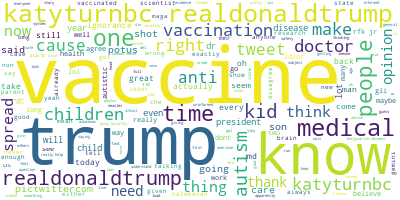

In [26]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

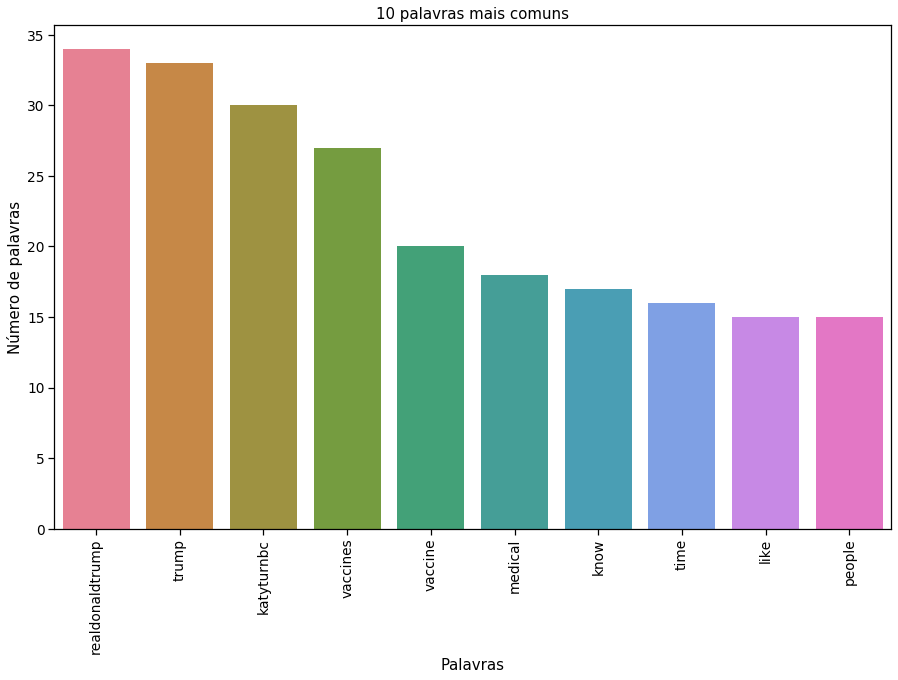

In [27]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['processed_text'])# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [28]:
# Tweak the two parameters below
number_topics = 5
number_words = 10# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
vaccines katyturnbc trump realdonaldtrump cause doctor vaccine like doesn let

Topic #1:
trump realdonaldtrump going katyturnbc opinion pictwittercom benjysarlin people vaccine nbcnews

Topic #2:
realdonaldtrump medical know katyturnbc people did don vaccines autism vaccination

Topic #3:
vaccines katyturnbc realdonaldtrump trump great kids right anti pictwittercom vaccine

Topic #4:
children trump said spread time shots vaccine gemini potus katyturnbc


In [29]:
data = df.text.values.tolist()
data_words = list(sent_to_words(data))

In [30]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [35]:
data_ready = process_words(data_words)

In [36]:
id2word = corpora.Dictionary(data_ready)

In [37]:
corpus = [id2word.doc2bow(text) for text in data_ready]

In [38]:
#frequencia de cada palavra em cada documento
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus]

In [39]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [40]:
print(lda_model.print_topics())

[(0, '0.036*"people" + 0.012*"thing" + 0.012*"disagree" + 0.012*"let" + 0.011*"everyone" + 0.010*"way" + 0.009*"sure" + 0.009*"post" + 0.009*"show" + 0.008*"feel"'), (1, '0.048*"medical" + 0.037*"antivaxxer" + 0.034*"live" + 0.031*"parallel" + 0.031*"universe" + 0.029*"graduate" + 0.020*"vaccination" + 0.014*"kid" + 0.013*"actually" + 0.012*"opinion"'), (2, '0.051*"really" + 0.018*"trump" + 0.017*"man" + 0.013*"anti" + 0.012*"tweet" + 0.011*"long" + 0.011*"president" + 0.010*"gli" + 0.009*"year" + 0.008*"ignorance"'), (3, '0.053*"vaccine" + 0.030*"school" + 0.029*"time" + 0.024*"spread" + 0.015*"give" + 0.014*"child" + 0.013*"shot" + 0.012*"autism" + 0.012*"work" + 0.011*"care"')]


In [41]:
#how good a given topic model is = fazer varios modelos com n topicos e pegar a maior coherence score
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.969326683774137

Coherence Score:  0.612992308635776


In [42]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [43]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

In [44]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.4518,"really, trump, man, anti, tweet, long, preside...","[always, great, hear, trump]"
1,1,0.0,0.2500,"people, thing, disagree, let, everyone, way, s...",[]
2,2,3.0,0.4509,"vaccine, school, time, spread, give, child, sh...","[guess, give, great, doctor]"
3,3,0.0,0.5712,"people, thing, disagree, let, everyone, way, s...","[give, god, never, bad, reaction, mom, dad, co..."
4,4,1.0,0.7135,"medical, antivaxxer, live, parallel, universe,...","[omg, actually, agree, something, scary]"
5,5,3.0,0.8124,"vaccine, school, time, spread, give, child, sh...","[yrs, child, shot]"
6,6,0.0,0.6151,"people, thing, disagree, let, everyone, way, s...",[march]
7,7,0.0,0.6054,"people, thing, disagree, let, everyone, way, s...",[september]
8,8,2.0,0.4169,"really, trump, man, anti, tweet, long, preside...","[opinion, trump]"
9,9,3.0,0.8481,"vaccine, school, time, spread, give, child, sh...","[doctor, vaccine, autism, debunk]"


In [45]:
pd.options.display.max_colwidth = 100

In [46]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

In [47]:
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9366,"people, thing, disagree, let, everyone, way, sure, post, show, feel","[disagree, current, administration, opponent, feel, fine, disagree, thought, label, loser, hypoc..."
1,1.0,0.9604,"medical, antivaxxer, live, parallel, universe, graduate, vaccination, kid, actually, opinion","[afaict, core, republican, belief, boil, hurt, offend, lib, live, world, insane, fantasy, nothin..."
2,2.0,0.9750,"really, trump, man, anti, tweet, long, president, gli, year, ignorance","[tutti, gli, sono, anti, vaccino, sono, contrario, sparare, dosi, massicce, bambini, piccoli, sp..."
3,3.0,0.9581,"vaccine, school, time, spread, give, child, shot, autism, work, care","[obviously, parent, visit, pediatrician, single, immunization, pay, doctor, visit, vaccine, work..."


In [70]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"folk, really, children, kid, give, vaccine, vaccinate, live, doctor, time",75.0,0.2560
1.0,1.0,"today, never, maybe, president, tell, child, head, back, omg, mean",82.0,0.2799
2.0,2.0,"folk, really, children, kid, give, vaccine, vaccinate, live, doctor, time",67.0,0.2287
3.0,3.0,"trump, vaccine, tweet, people, general, elect, great, wait, deep, measle",69.0,0.2355
4.0,0.0,"man, health, gut, autism, love, stunning, way, sheen, charlie, schneider",NaN,NaN
...,...,...,...,...
288.0,2.0,"folk, really, children, kid, give, vaccine, vaccinate, live, doctor, time",NaN,NaN
289.0,2.0,"folk, really, children, kid, give, vaccine, vaccinate, live, doctor, time",NaN,NaN
290.0,0.0,"man, health, gut, autism, love, stunning, way, sheen, charlie, schneider",NaN,NaN
291.0,0.0,"man, health, gut, autism, love, stunning, way, sheen, charlie, schneider",NaN,NaN


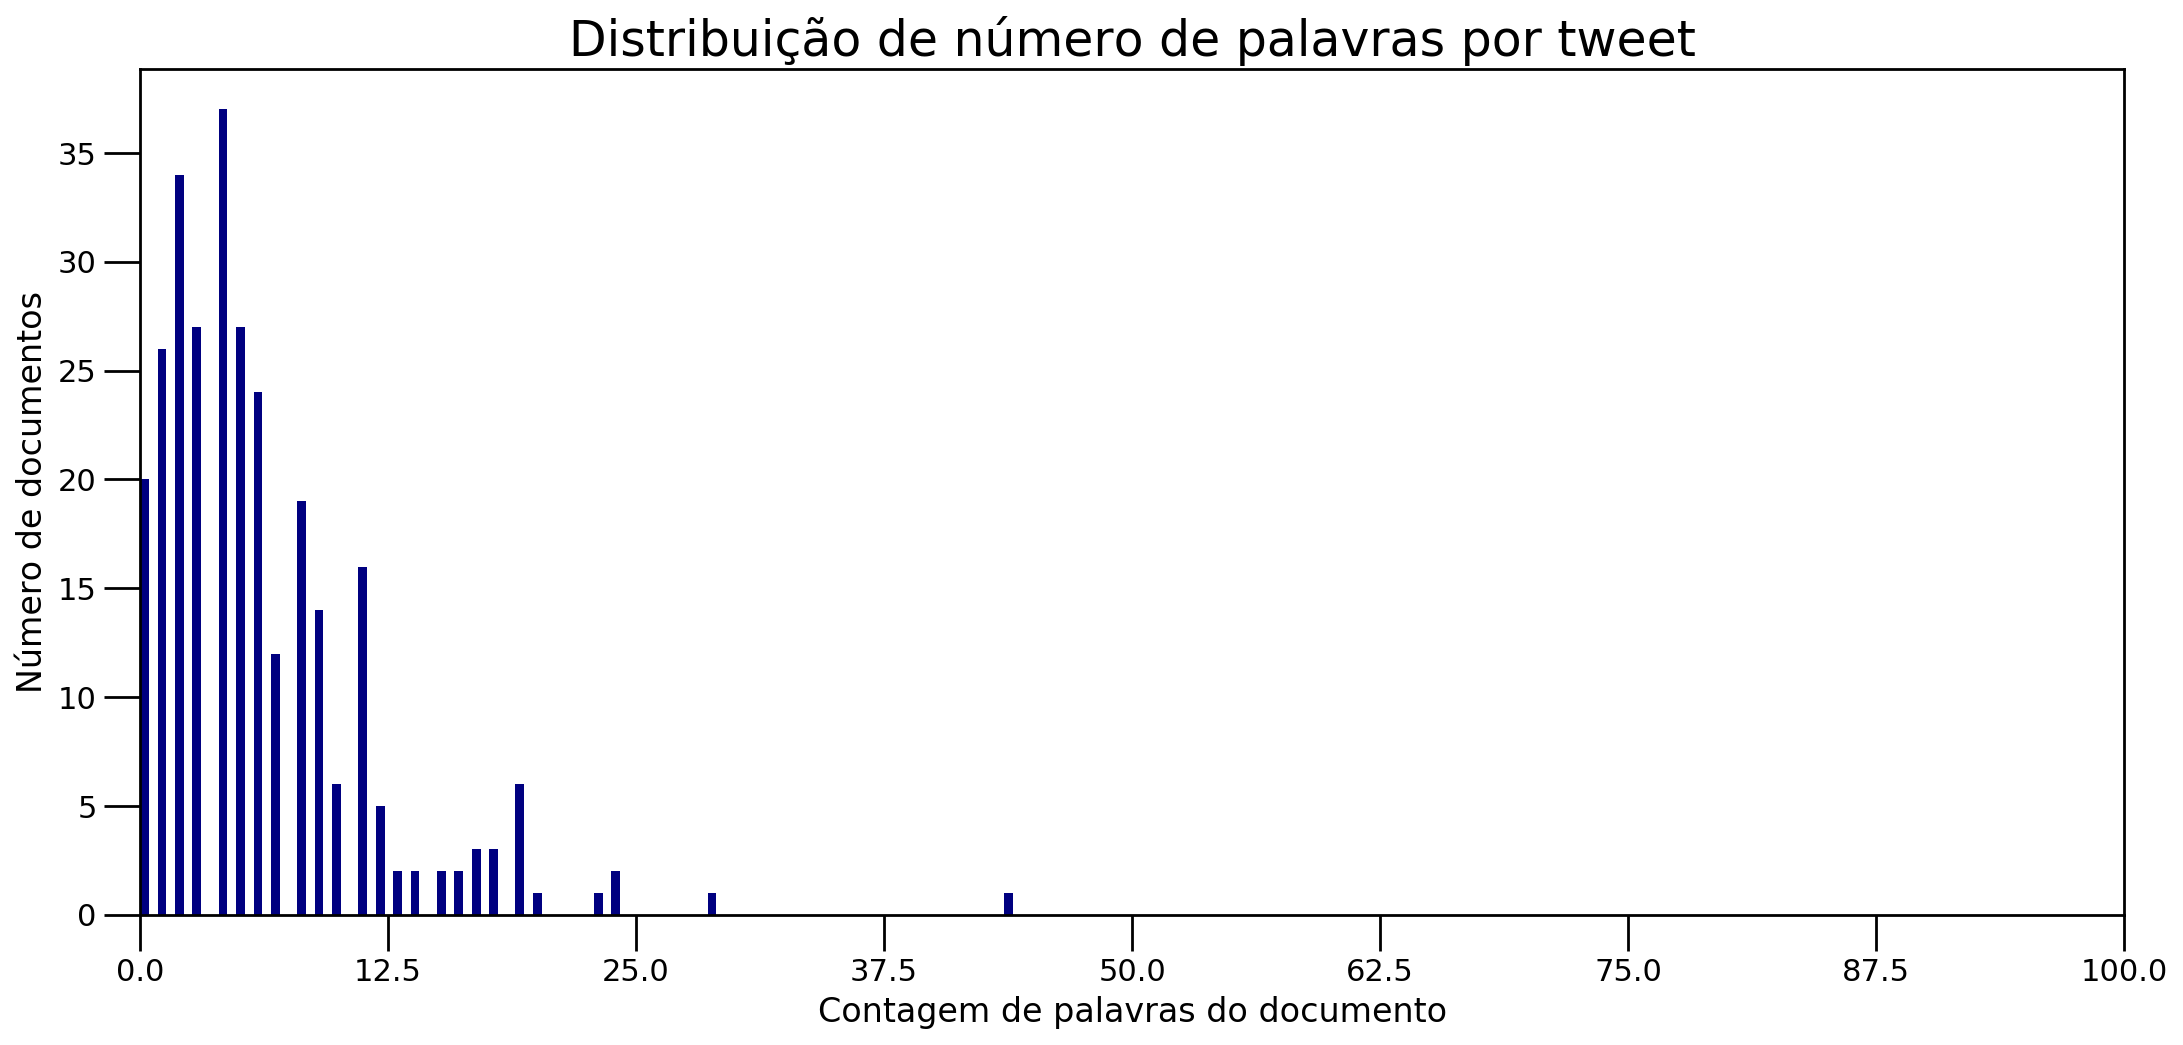

In [78]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 100, color='navy')
#plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
#plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
#plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
#plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
#plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Número de documentos', xlabel='Contagem de palavras do documento')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,100,9))
plt.title('Distribuição de número de palavras por tweet', fontdict=dict(size=22))
plt.show()

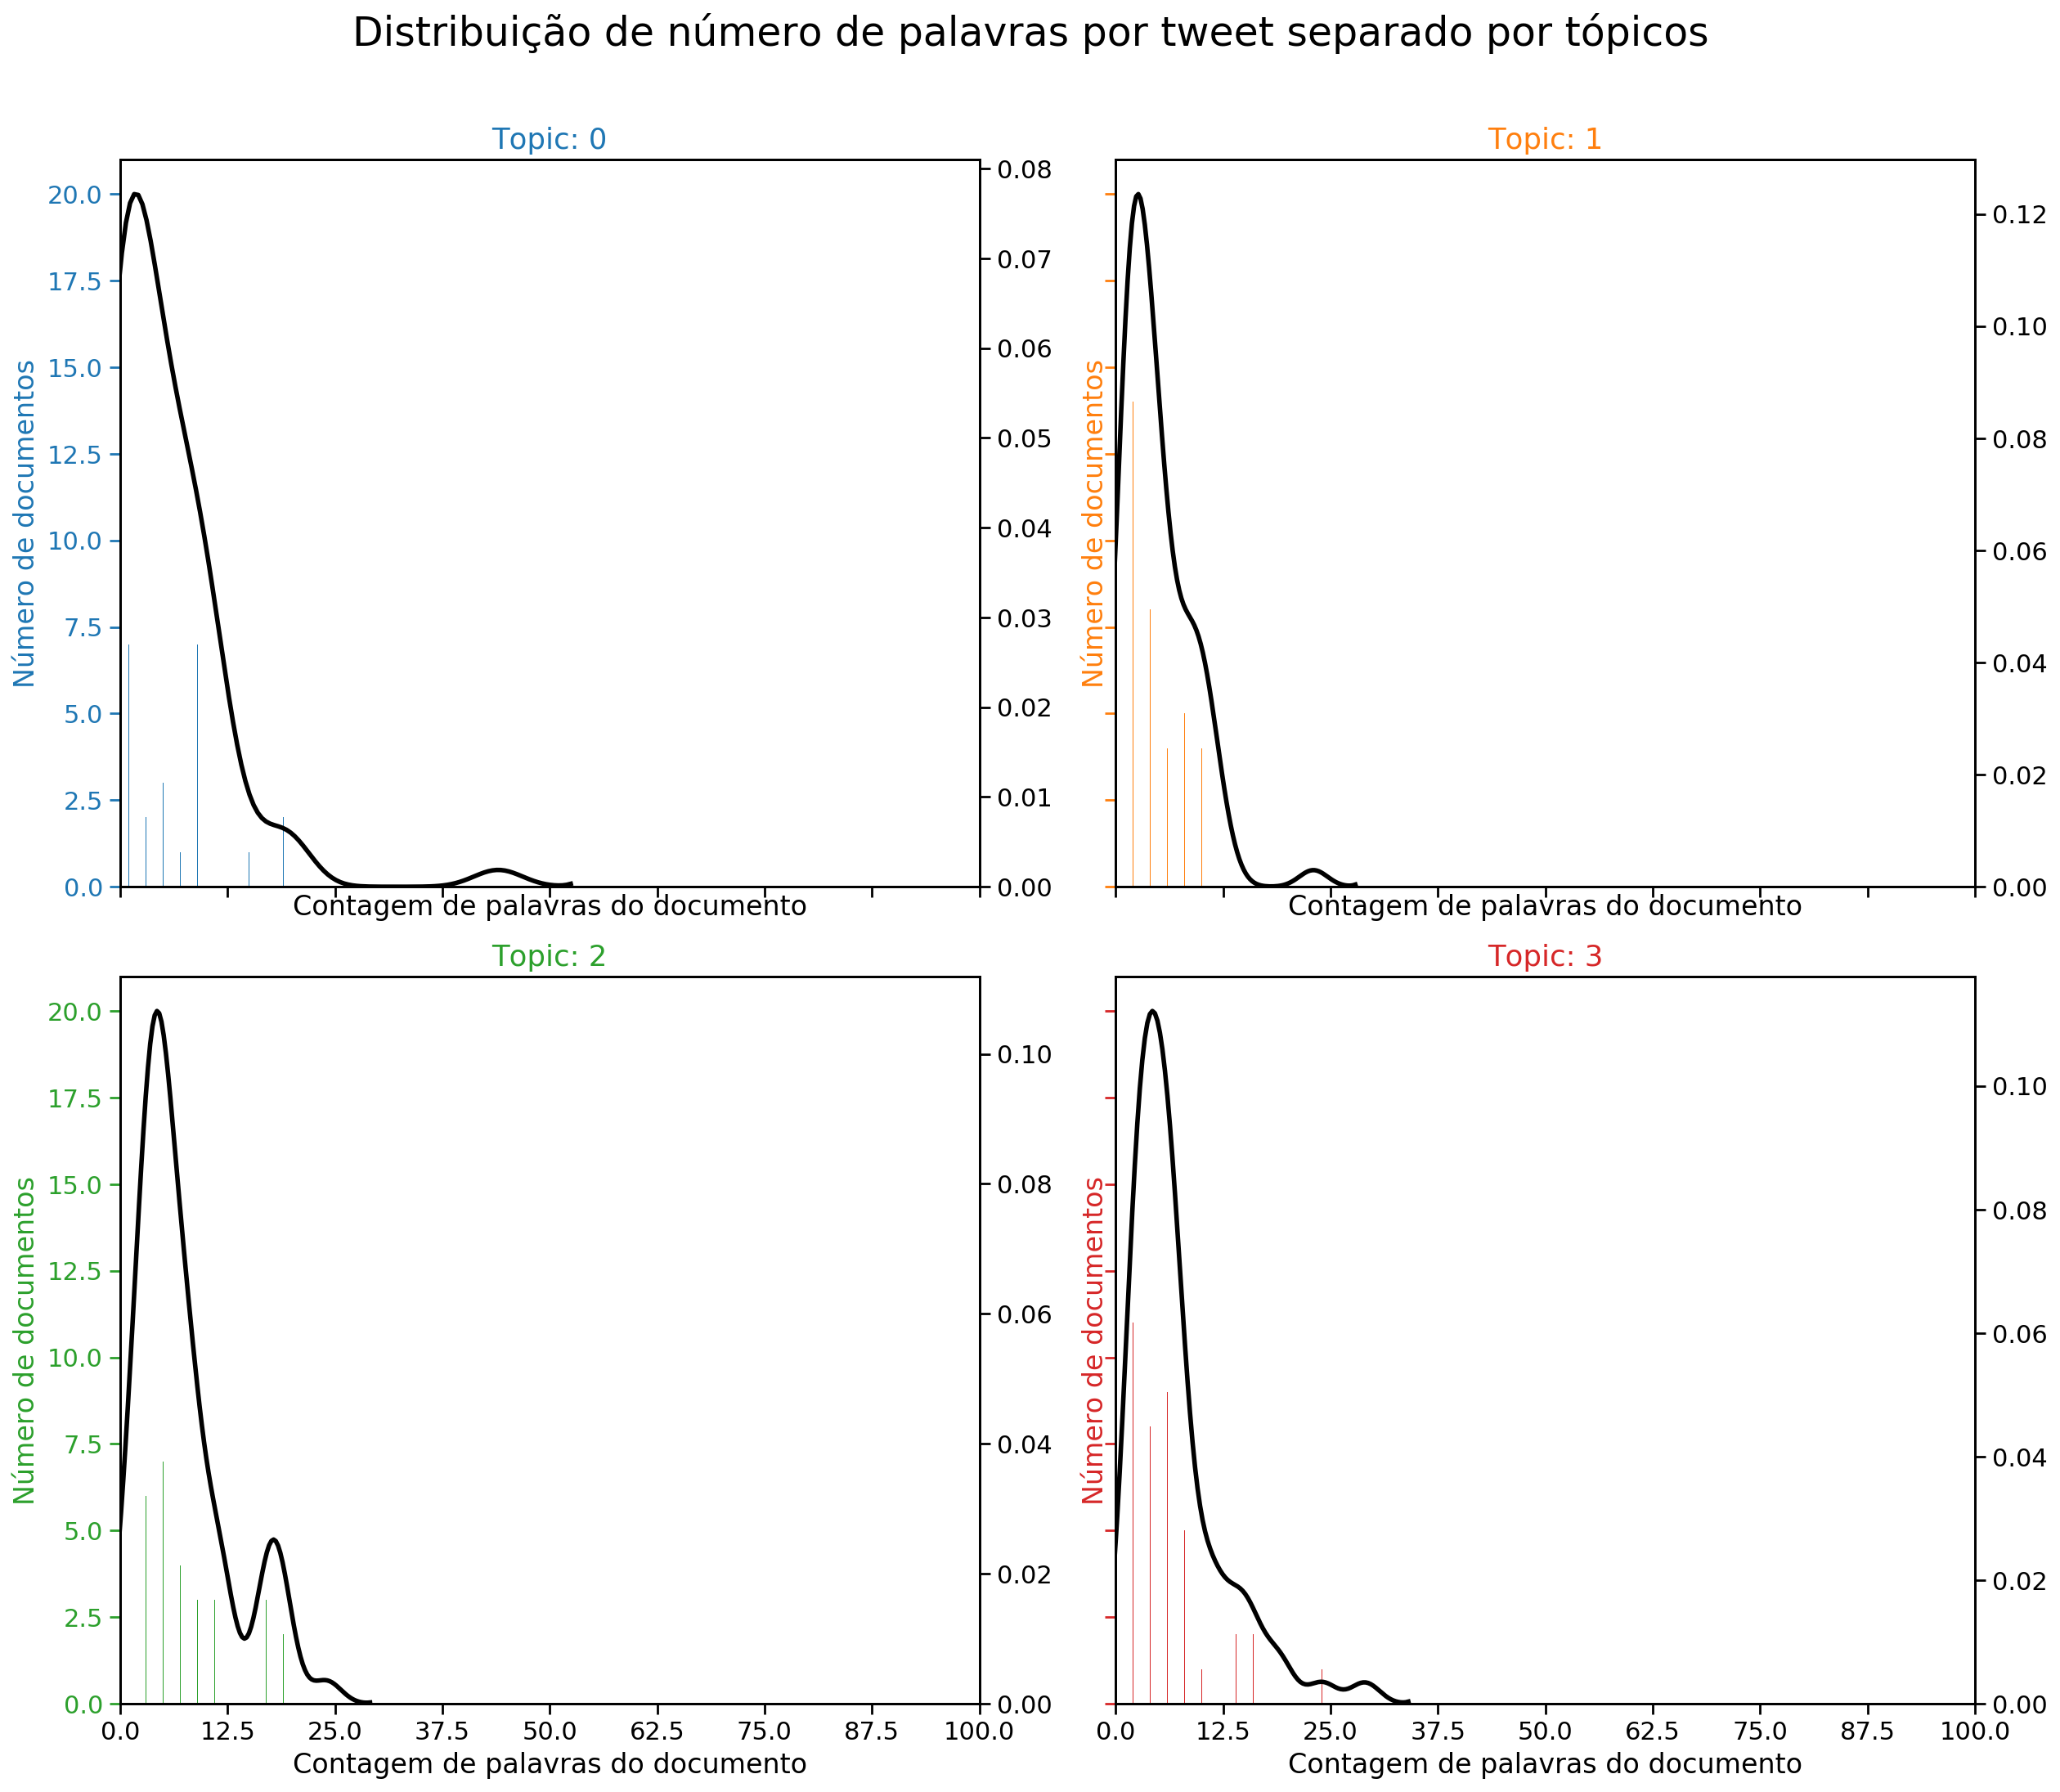

In [79]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 100), xlabel='Contagem de palavras do documento')
    ax.set_ylabel('Número de documentos', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,100,9))
fig.suptitle('Distribuição de número de palavras por tweet separado por tópicos', fontsize=22)
plt.show()

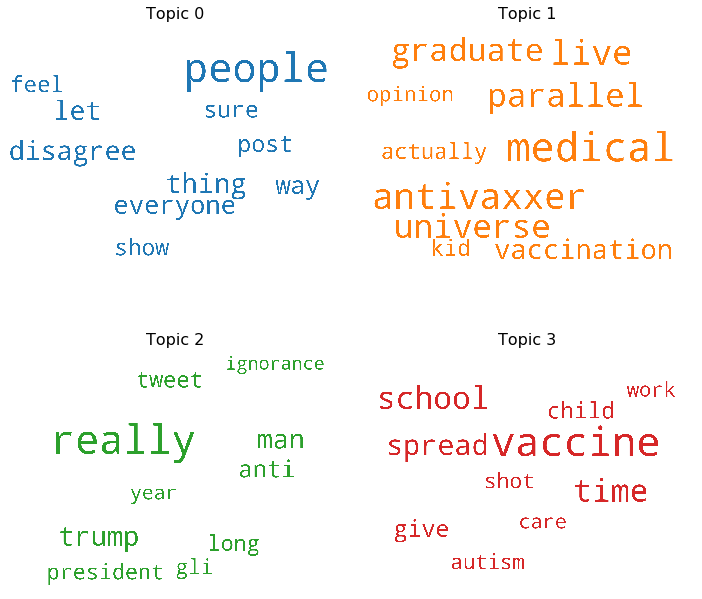

In [48]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

#tamanho das palavras proporcional ao peso
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

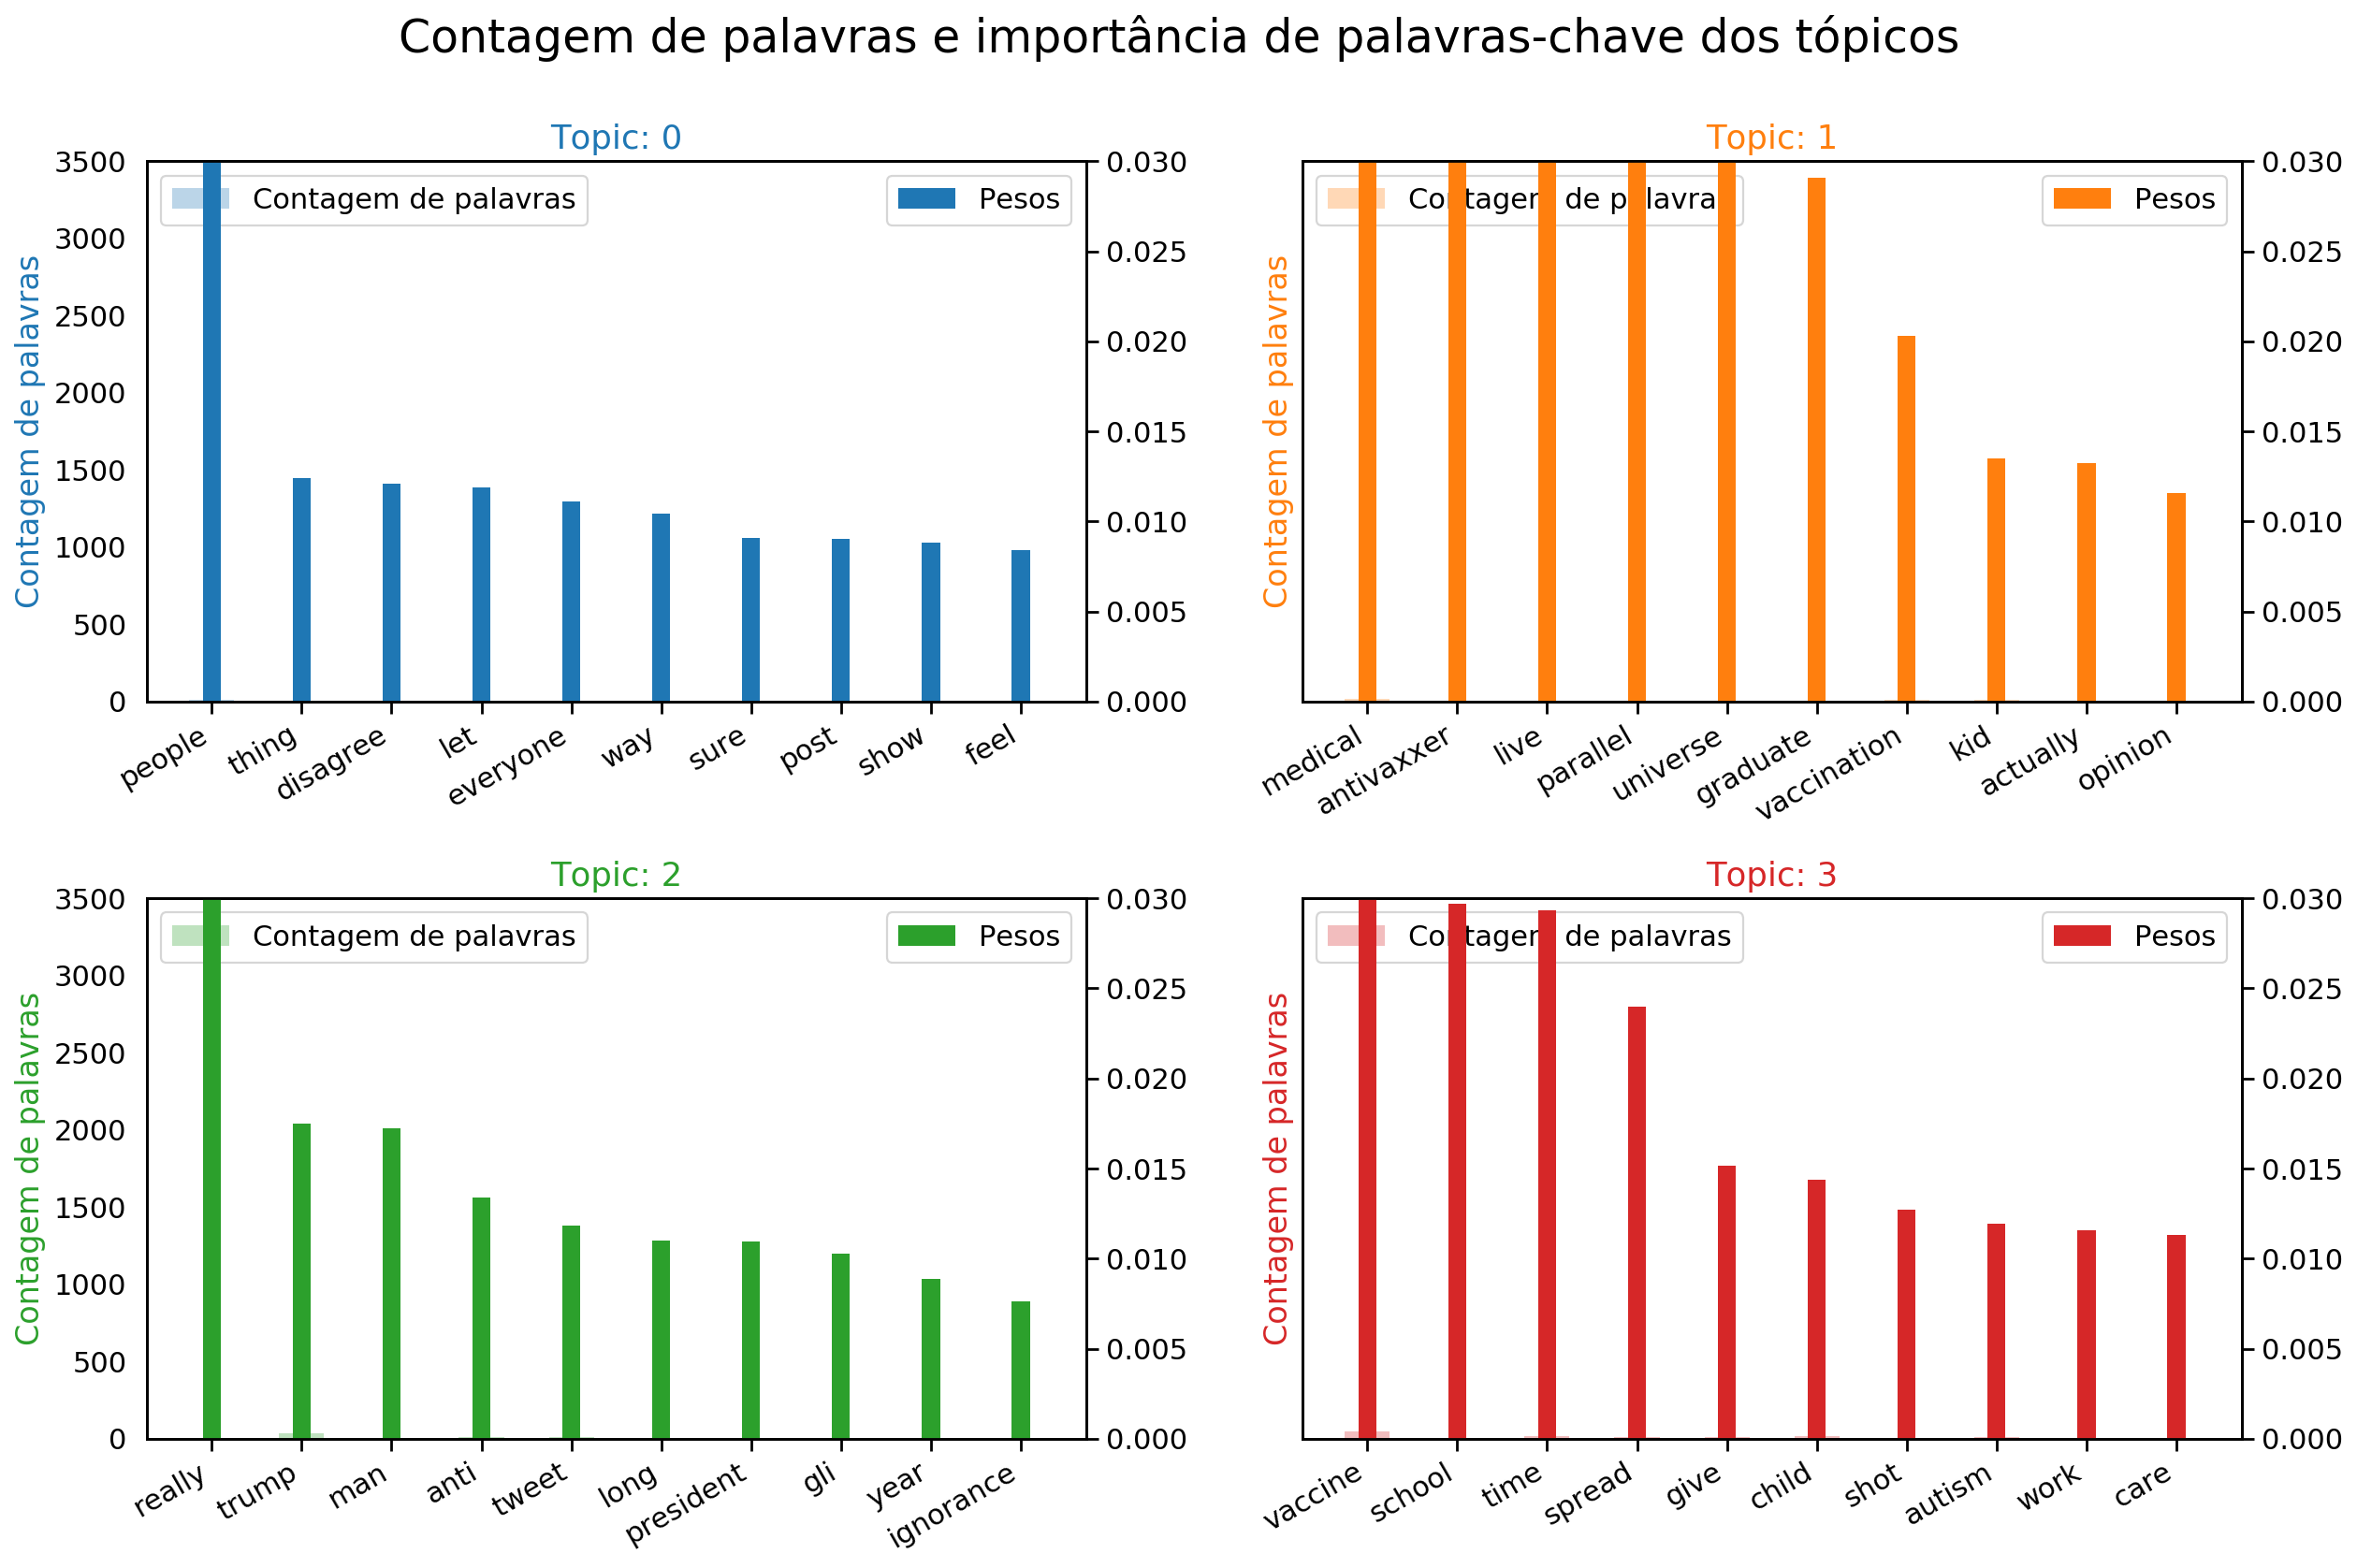

In [49]:
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Contagem de palavras')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Pesos')
    ax.set_ylabel('Contagem de palavras', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
#palavras com o a frequencia maior q o peso ou palavras q aparecem em varios topicos podem indicar possíveis stop words
fig.tight_layout(w_pad=2)    
fig.suptitle('Contagem de palavras e importância de palavras-chave dos tópicos', fontsize=22, y=1.05)    
plt.show()

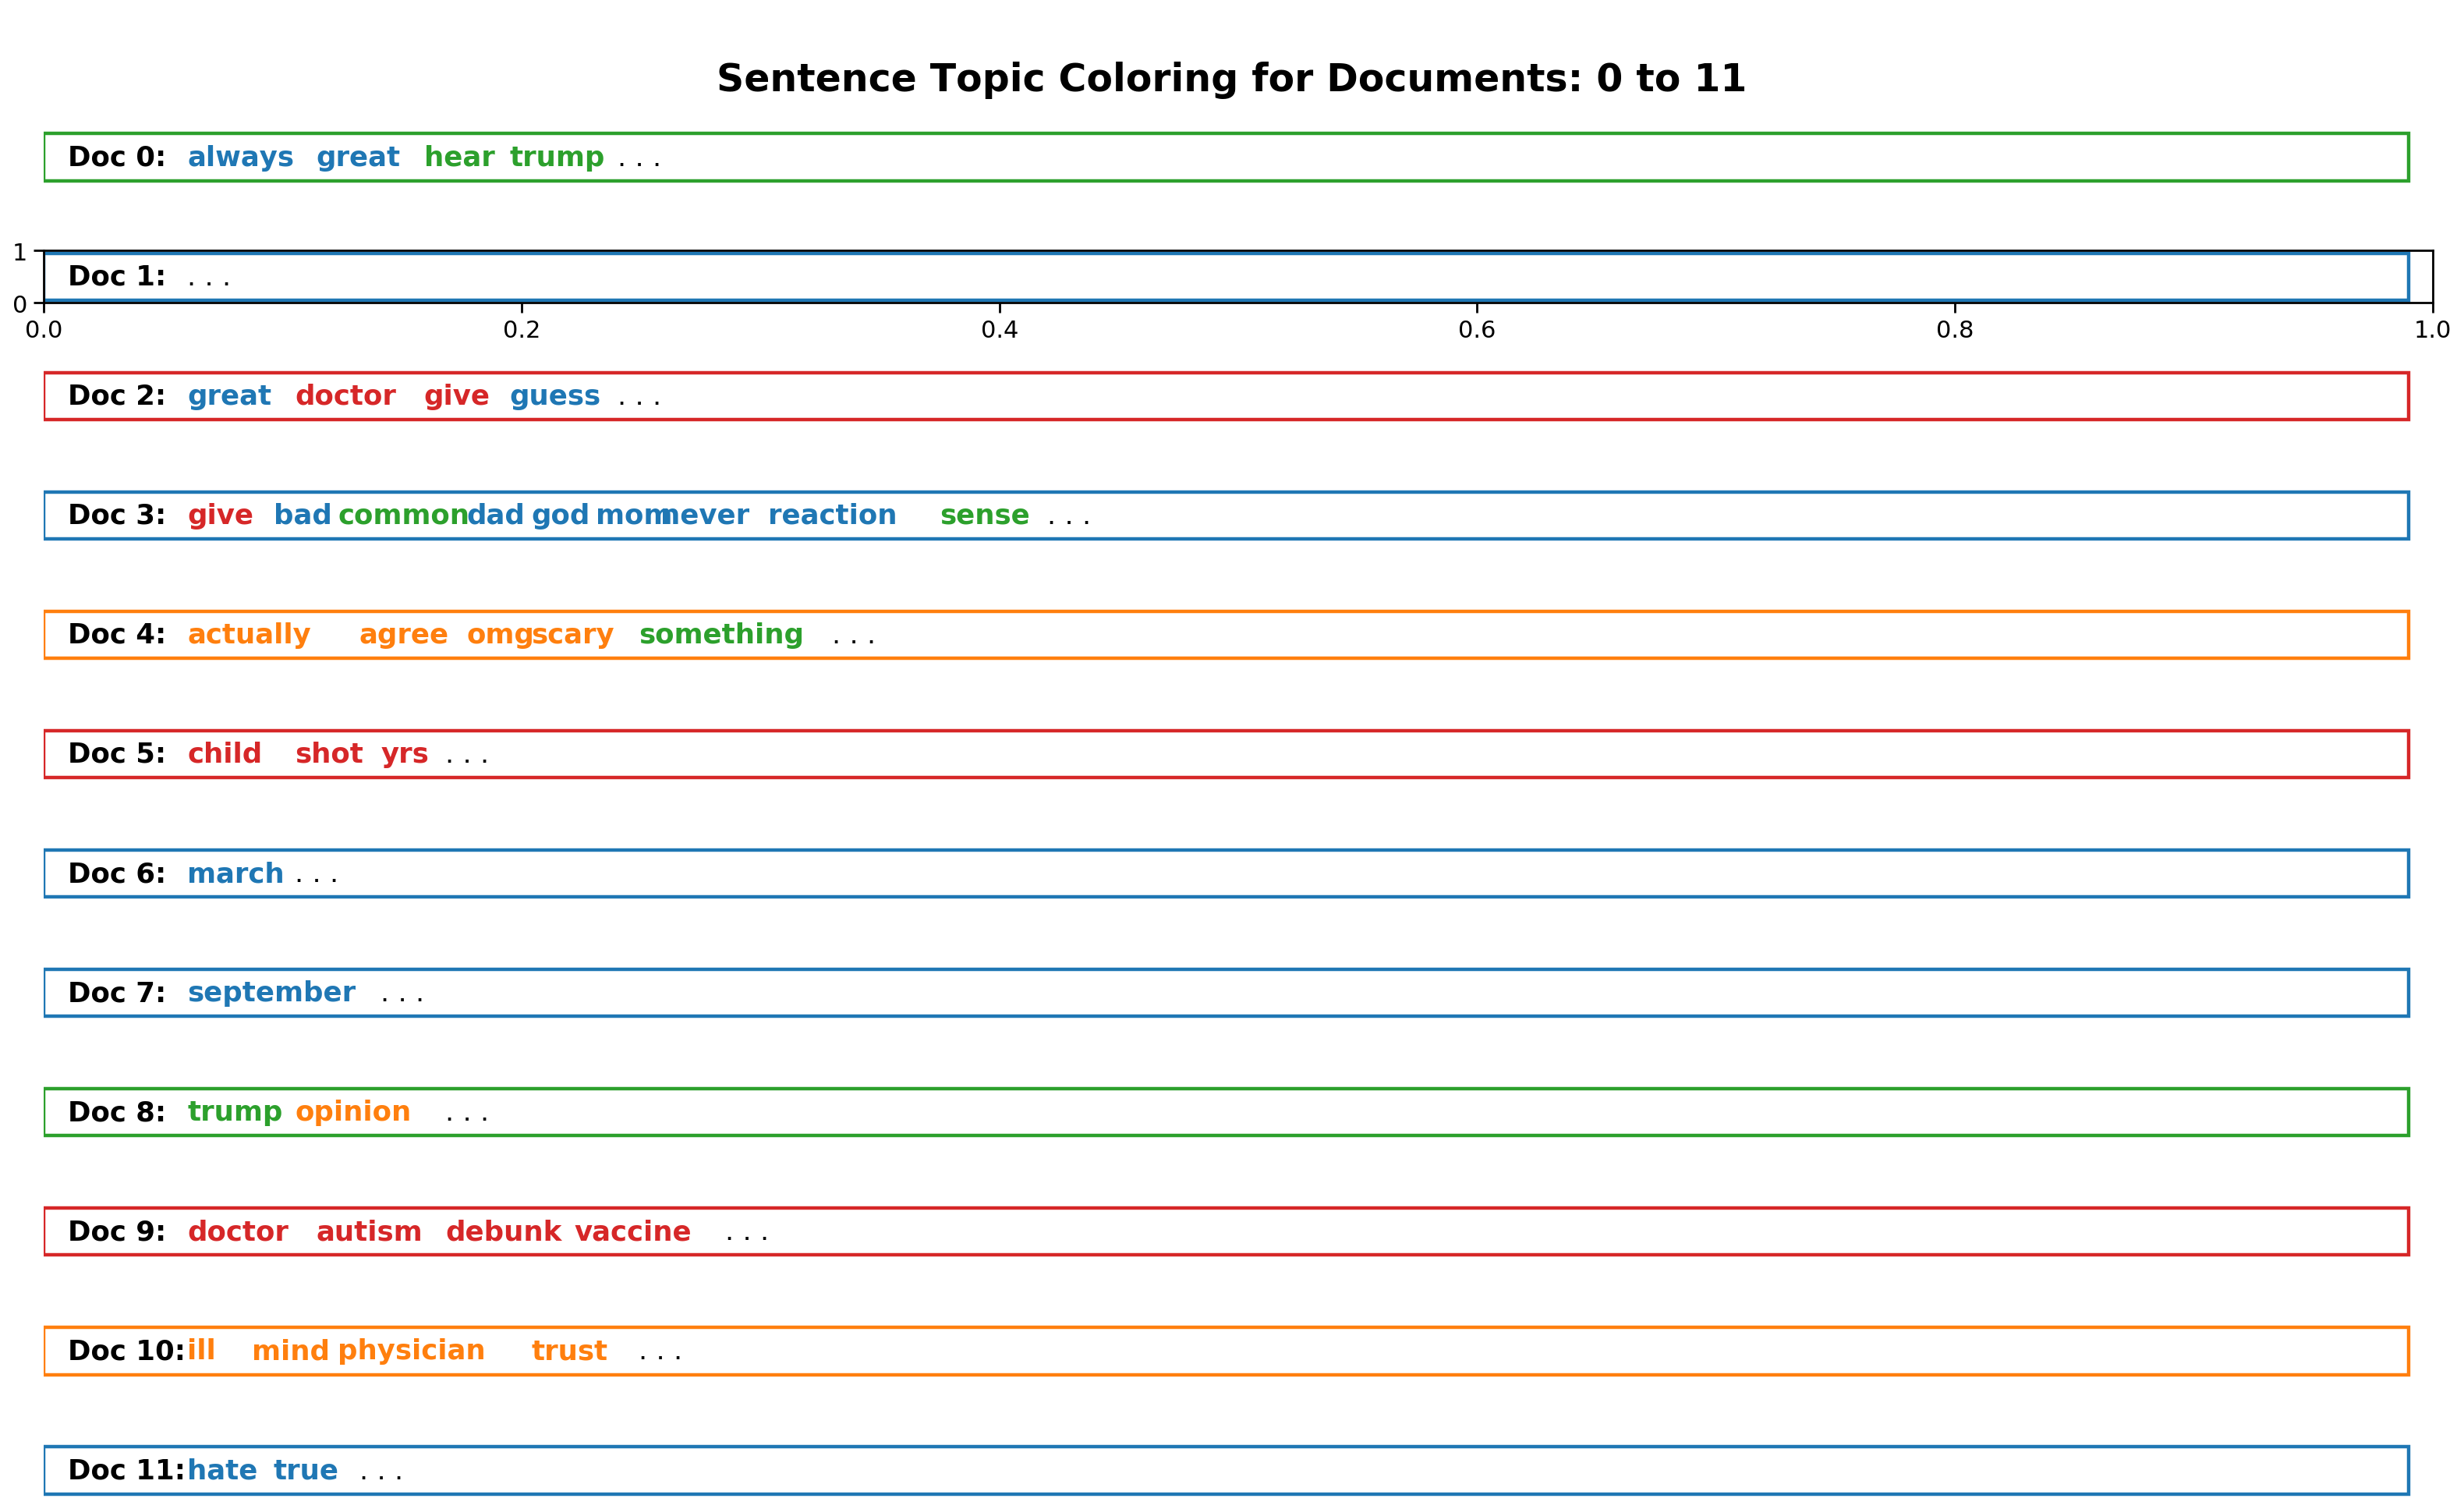

In [50]:
sentences_chart(lda_model, corpus)

In [51]:
dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

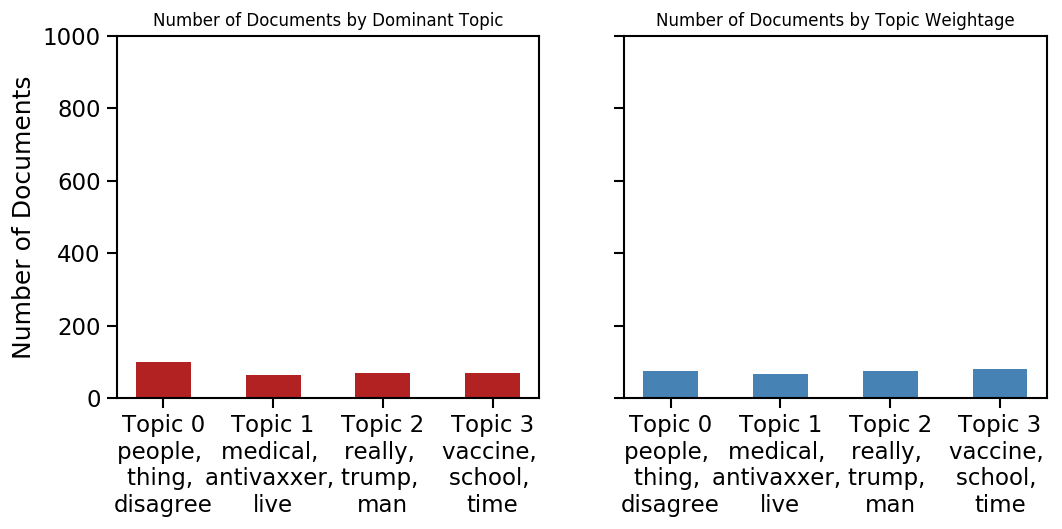

In [52]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [53]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 278 samples in 0.001s...
[t-SNE] Computed neighbors for 278 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 278 / 278
[t-SNE] Mean sigma: 0.102374
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.876850
[t-SNE] KL divergence after 1000 iterations: 0.176356


Loading BokehJS ...

In [54]:
'''Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

The words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.'''
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/home/arthur/Área de Trabalho/CodigosTCC/venv/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.161473  0.064431       1        1  29.410421
2     -0.042199 -0.154431       2        1  27.669943
0      0.018757 -0.028689       3        1  22.349243
1     -0.138031  0.118688       4        1  20.570395, topic_info=     Category       Freq        Term      Total  loglift  logprob
28    Default  28.000000     vaccine  28.000000  30.0000  30.0000
394   Default  26.000000      really  26.000000  29.0000  29.0000
49    Default  18.000000     medical  18.000000  28.0000  28.0000
132   Default  15.000000      people  15.000000  27.0000  27.0000
1016  Default  14.000000  antivaxxer  14.000000  26.0000  26.0000
...       ...        ...         ...        ...      ...      ...
78     Topic4   1.863404         ask   3.025759   1.0966  -5.3034
676    Topic4   1.435035    honestly   2.298428   1.1103  -5.5646
1019   Topic4   1.469998       foggy   2.880677   0.9086  -5.5406
1018   Topic4   1.469998    comeback   2.880677   0.9086  -5.5406
1017   Topic4   1.469998     classic   2.880677   0.9086  -5.5406

[174 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
15        4  0.905840  actually
441       3  0.747365   address
16        4  0.797829     agree
353       4  0.855826   already
71        2  0.963628      anti
...     ...       ...       ...
537       3  0.836351       way
613       4  0.782058      week
428       1  0.886221      work
153       1  0.788319     wrong
254       2  0.800656      year

[168 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])